# Turtle Recall
A facial recognition model for turtles

https://zindi.africa/competitions/turtle-recall-conservation-challenge/data

# Imports

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from PIL import Image

In [246]:
from util import IMAGE_DIR, NUM_CLASSES, BATCH_SIZE

# Dataset

In [8]:
train_ds = pd.read_csv("./data/train.csv")
# test set not required since not annotated
test_ds = pd.read_csv("./data/test.csv")

# Convert image_location strings to lowercase.
for df in [train_ds, test_ds]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [9]:
train_ds.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [10]:
test_ds.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [11]:
train_ds.shape, test_ds.shape

((2145, 3), (490, 2))

The mean number of training images per turtle is 21.45, and the median is 16.


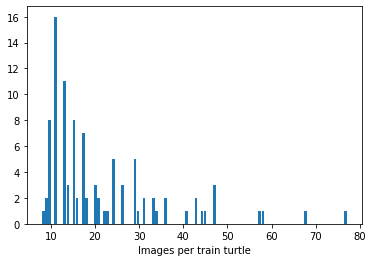

In [23]:
train_images_per_turtle = pd.value_counts(train_ds['turtle_id'])
print('The mean number of training images per turtle is '
      f'{round(np.mean(train_images_per_turtle), 2)}, '
      f'and the median is {int(np.median(train_images_per_turtle))}.')
plt.hist(x=train_images_per_turtle, rwidth=0.9, bins=100)
plt.xlabel('Images per train turtle')
plt.show()

The mean number of training images per turtle is 21.45, and the median is 16.


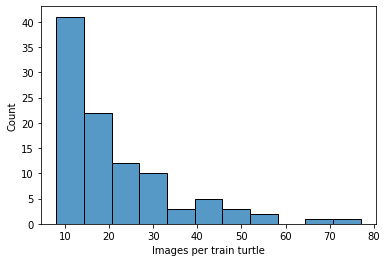

In [19]:
train_images_per_turtle = pd.value_counts(train_ds['turtle_id'])
print('The mean number of training images per turtle is '
      f'{round(np.mean(train_images_per_turtle), 2)}, '
      f'and the median is {int(np.median(train_images_per_turtle))}.')
sns.histplot(train_images_per_turtle)
plt.xlabel('Images per train turtle')
plt.show()

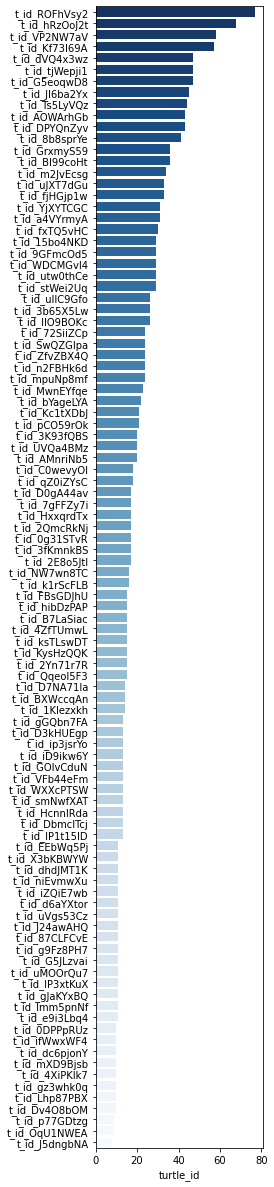

In [25]:
images_per_turtle = pd.value_counts(train_ds['turtle_id'])
plt.figure(figsize=(3, 21))
sns.barplot(x=images_per_turtle, y=images_per_turtle.index,
            palette='Blues_r', orient='horizontal')
plt.show()

# Preprocessing

Create three mappings and get the paths to the training set image files.
1. `labels` : turtle ID --> unique integer labels
1. `label_lookup` : unique integer labels --> turtle ID
1. `image_to_turtle` :  image IDs to turtle IDs (training set only).

In [ ]:
# from tutorial.ipynb, but not currently used in pipeline
turtle_ids = sorted(np.unique(train_ds.turtle_id)) + ['new_turtle']

In [ ]:
# required by current pipeline
# consider moving to util.py
image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.split('.')[0] in train_ds.image_id.values]

loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]
image_ids = [os.path.basename(f).split('.')[0] for f in image_files]

image_to_turtle = dict(zip(train_ds.image_id, train_ds.turtle_id))
labels = dict(zip(turtle_ids, np.arange(len(turtle_ids))))

loaded_labels = [labels[image_to_turtle[id]] for id in image_ids]

In [134]:
# from tutorial.ipynb, but not currently used in pipeline
label_lookup = {v: k for k, v in labels.items()}
num_classes = len(labels)

image_turtle_ids = [image_to_turtle[id] for id in image_ids]

In [32]:
from preprocessing import crop_and_resize

tqdm.tqdm._instances.clear()
loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]

100%|██████████| 2145/2145 [00:45<00:00, 46.89it/s]


In [194]:
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(np.stack([np.asarray(im, dtype=np.float32) for im in loaded_images])), 
    tf.data.Dataset.from_tensor_slices(np.stack(loaded_labels))
    ))

In [195]:
ds = ds.map(lambda x,y: (x/255., tf.one_hot(y, NUM_CLASSES)))

In [238]:
train = ds.take(1500).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = ds.skip(1500).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

### Batches like done in tutorial.ipynb

In [33]:
probability_per_label = {
    label: 1 / label_count / len(train_images_per_turtle)
    for label, label_count in train_images_per_turtle.items()
}

probabilities = [
    probability_per_label[image_turtle_id]
    for image_turtle_id in image_turtle_ids
]
assert np.isclose(1., np.sum(probabilities))


def get_batch(batch_size, rebalance=False):
  if rebalance:
    probs = probabilities
  else:
    probs = None
  batch_image_idxs = np.random.choice(
      len(image_files), size=batch_size, replace=False, p=probs)
  input_images = [loaded_images[idx] for idx in batch_image_idxs]
  image_labels = [labels[image_turtle_ids[idx]] for idx in batch_image_idxs]
  return (
      np.stack([np.asarray(im, dtype=np.float32) / 255. for im in input_images]), 
      np.stack(image_labels).astype(np.int32))

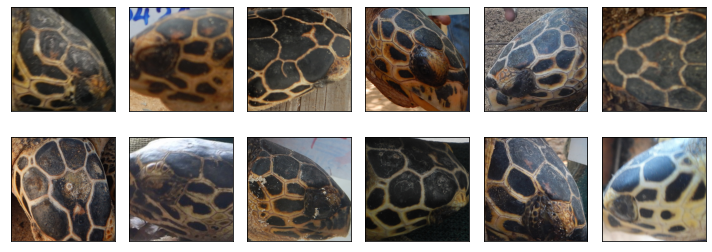

[37 34 66 75 22 56 21 12 79 80 74 80]


In [48]:
batch_images, batch_labels = get_batch(batch_size=12)

_, axes = plt.subplots(nrows=2, ncols=6, figsize=(10, 4))
axes = axes.flatten()
for img, ax in zip(list(batch_images), axes):
  ax.imshow(img)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

print(batch_labels)

# Training

In [231]:
from training_functions import training_loop
from models.alexNet import AlexNet
from util import NR_EPOCHS

Training progress: 100%|██████████| 100/100 [1:29:58<00:00, 53.99s/epoch, Loss 4.618164539337158]  


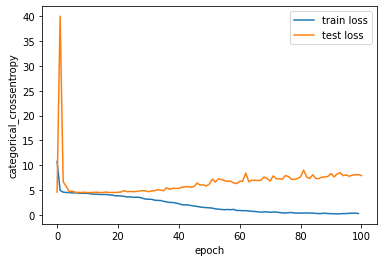

In [245]:
alexnet = AlexNet()
adam = tf.keras.optimizers.Adam()
cce = tf.keras.losses.CategoricalCrossentropy()

training_loop(train, test, alexnet, cce, adam, NR_EPOCHS)